# Simple pix2pix implemented in Keras

## Mount google drive

In [0]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/sirius/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import os
import tarfile
import urllib
from keras.preprocessing import image as kimage
import keras
from keras.models import Sequential, Model
from keras.layers import *
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

## Load dataset

### Download data and unpack it if necessary

In [0]:
if 'edges2handbags' not in os.listdir():
  # this two commands run whole fucking life
  !wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/edges2handbags.tar.gz
  !tar -xvf edges2handbags.tar.gz

### Create dataflow

In [0]:
PATH = "edges2handbags/"
IMAGE_SHAPE = (256, 256, 3)
HALF_IMAGE_SHAPE = (256, 128, 3)
BATCH_SIZE = 4
HALF_BATCH_SIZE = BATCH_SIZE // 2

datagen = keras.preprocessing.image.ImageDataGenerator(
  rescale=1.0/255,
)

# Generator which yields train batches
train_generator = datagen.flow_from_directory(
    directory=PATH,
    target_size=IMAGE_SHAPE[:2],
    color_mode="rgb",
    batch_size=HALF_BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)


def scale(x):
  return x * 255

Found 20866 images belonging to 1 classes.


## Shit

In [0]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add


def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid', name="Unet_output") (c9)
    model = Model(inputs=[input_img], outputs=[outputs], name="Generator")
    return model

## Funcs which build models

In [0]:
def split_pic_from_batch(x):
  return x[:, :, :HALF_IMAGE_SHAPE[1], :], x[:, :, HALF_IMAGE_SHAPE[1]:, :], 

In [0]:
def noisy(images):
  for i in range(len(images)):
    image = images[i]
    row,col,ch= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    images[i] = image + gauss
  return images

In [0]:
class Pipi(object):
    
  EPOCHS = 5000
  
  def __init__(self, data_generator):
    self.train_generator = data_generator
    self.generator = self.create_generator()
    self.discriminator = self.create_discriminator()
    
    self.discriminator.trainable = False
    
    contour_input = Input(HALF_IMAGE_SHAPE, name='Contour')
    coloring_input = Input(HALF_IMAGE_SHAPE, name='Coloring')

    probs = self.discriminator([contour_input, coloring_input])
    generated = self.generator(contour_input)
    
    self.gen_and_disc = Model(
      inputs=[contour_input, coloring_input], outputs=[generated, probs], name='Gen_and_disc'
    )
    
    self.gen_and_disc.compile(
      loss={'Generator': 'mae','Discriminator': 'binary_crossentropy'},
      optimizer='RMSProp',
      metrics={'Generator': 'mae','Discriminator': 'acc'},
      loss_weights={'Generator': 100, 'Discriminator': 1}
    )


  def create_generator(self):
    contour_input = Input(HALF_IMAGE_SHAPE, name='Contour')
    gen = get_unet(contour_input)
    gen.compile(
      loss='mae', optimizer='RMSProp', metrics=['acc']
    )
    return gen


  def create_discriminator(self):
    contour_input = Input(HALF_IMAGE_SHAPE, name='Contour')
    coloring_input = Input(HALF_IMAGE_SHAPE, name='Coloring')
    cn1_b1 = Concatenate()([contour_input, coloring_input])
    c1_b1 = Conv2D(64, kernel_size=3, padding='same')(cn1_b1)
    mp_b1 = MaxPooling2D()(c1_b1)
    f_b2 = Flatten()(mp_b1)
    d1_b2 = Dense(16, activation='sigmoid')(f_b2)
    d2_b2 = Dense(1, activation='sigmoid', name='Discriminator_output')(d1_b2)
    disc = Model(inputs=[contour_input, coloring_input], outputs=d2_b2, name='Discriminator')
    disc.compile(
      loss='binary_crossentropy', optimizer='RMSProp', metrics=['acc']
    )
    return disc
  
  def train(self):
    valid = np.ones(HALF_BATCH_SIZE)
    fake = np.zeros(HALF_BATCH_SIZE)

    for epoch in range(self.EPOCHS):
        batch = self.train_generator.next()[0]
        contours, colorings = split_pic_from_batch(batch)
        noisy_colorings = noisy(colorings)

        generated = self.generator.predict(contours)

#         d_loss_real = self.discriminator.train_on_batch([contours, colorings], valid)
        d_metrics_real = self.discriminator.train_on_batch({ 
          'Contour': contours,
          'Coloring': noisy_colorings,},{
          'Discriminator_output': valid })

#         d_loss_fake = self.discriminator.train_on_batch([contours, generated], fake)
        d_metrics_fake = self.discriminator.train_on_batch({ 
          'Contour': contours,
          'Coloring': generated,},
          {'Discriminator_output': fake })
  
        d_metrics = 0.5 * np.add(d_metrics_real, d_metrics_fake)

#         g_loss = self.gen_and_disc.train_on_batch([contours, colorings], [colorings, valid])
        g_metrics = self.gen_and_disc.train_on_batch({
          'Contour': contours,
          'Coloring': noisy_colorings,},
          {'Generator': noisy_colorings,
          'Discriminator': valid})

        
        if not (epoch % 50):
          plt.figure()
          img = self.generator.predict(contours[:1])[0]
          if IMAGE_SHAPE[2] == 1:
            img = np.reshape(img, image_shape[:2])
          plt.imshow(colorings[0])
          plt.show()
          plt.imshow(img)
          plt.show()

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
W0716 11:10:00.355203 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


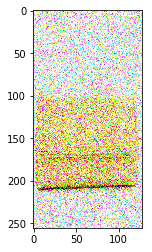

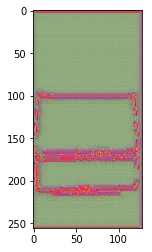

W0716 11:11:40.701205 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


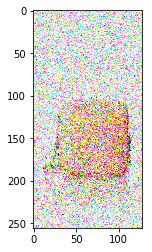

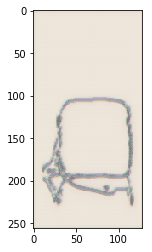

W0716 11:13:20.772645 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


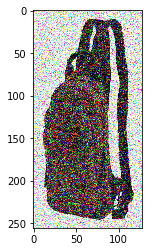

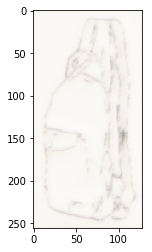

W0716 11:15:00.163369 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


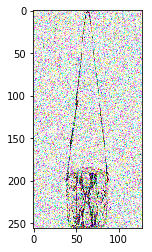

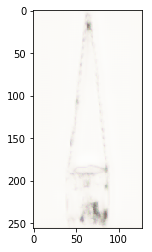

W0716 11:16:40.427380 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


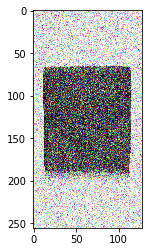

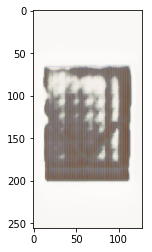

W0716 11:18:20.001819 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


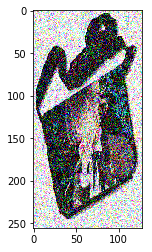

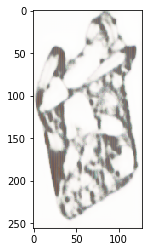

W0716 11:20:01.942605 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


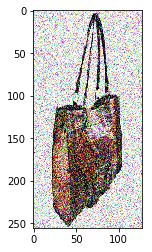

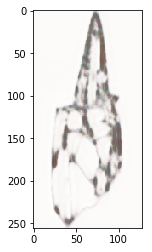

W0716 11:21:40.363275 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


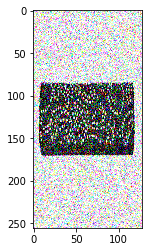

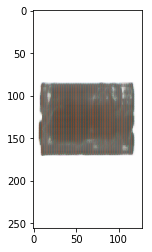

W0716 11:23:22.165211 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


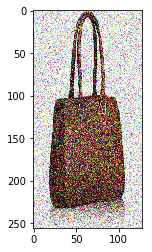

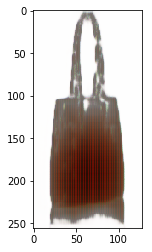

W0716 11:25:00.634016 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


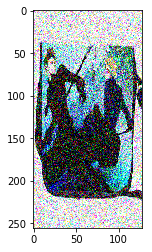

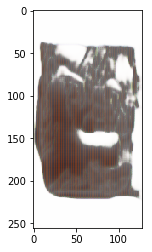

W0716 11:26:39.139468 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


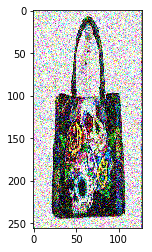

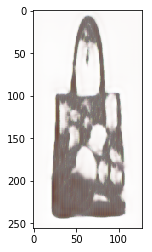

W0716 11:28:18.730061 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


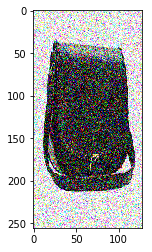

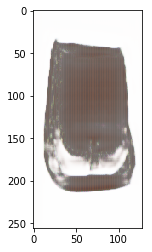

W0716 11:29:56.501230 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


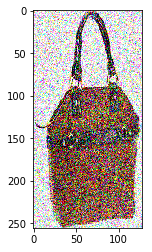

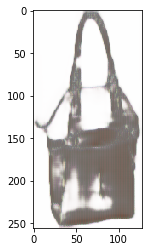

W0716 11:31:35.033653 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


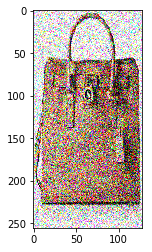

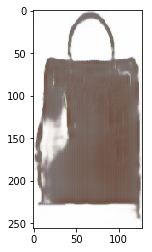

W0716 11:33:14.198441 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


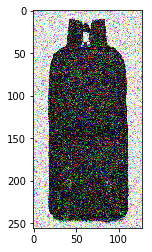

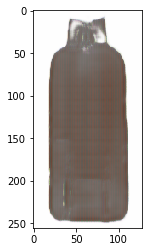

W0716 11:34:53.582212 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


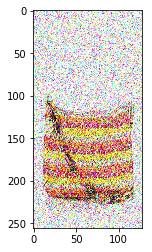

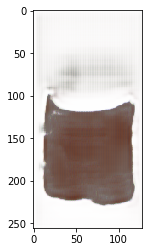

W0716 11:36:31.030555 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


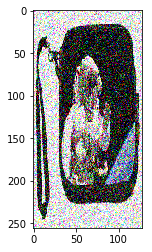

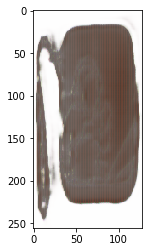

W0716 11:38:10.990582 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


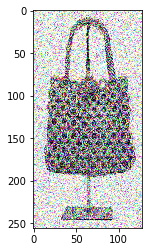

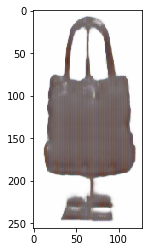

W0716 11:39:49.599504 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


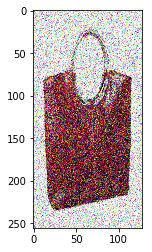

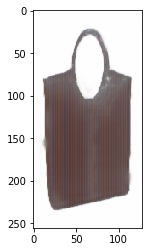

W0716 11:41:26.772448 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


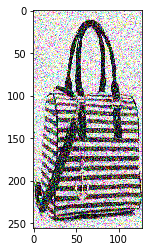

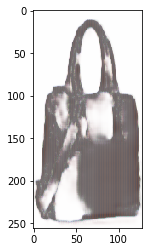

W0716 11:43:03.114784 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


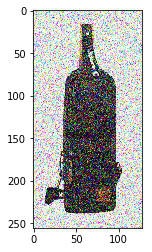

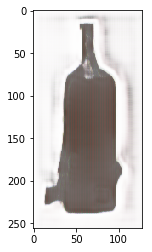

W0716 11:44:40.975855 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


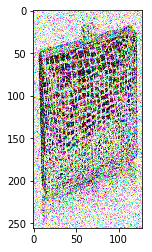

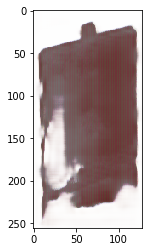

W0716 11:46:17.837329 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


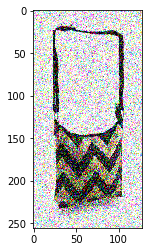

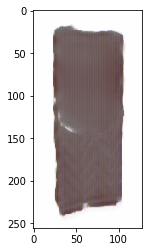

W0716 11:47:57.269690 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


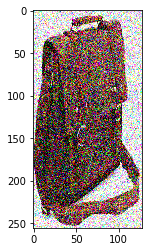

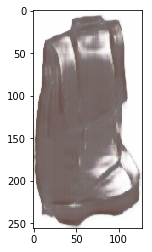

W0716 11:49:37.174635 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


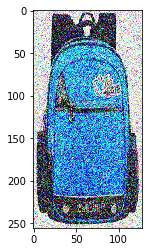

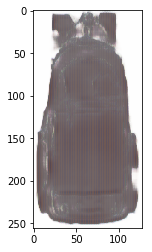

W0716 11:51:15.366500 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


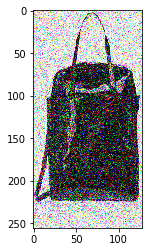

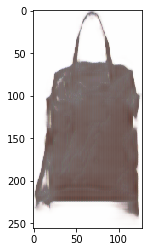

W0716 11:52:53.221504 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


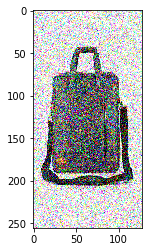

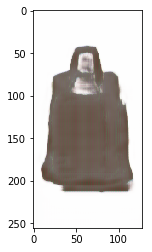

W0716 11:54:32.176626 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


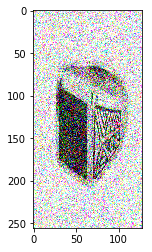

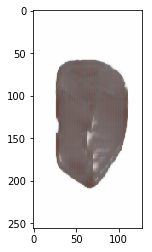

W0716 11:56:12.913108 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


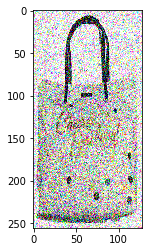

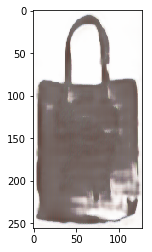

W0716 11:57:52.414896 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


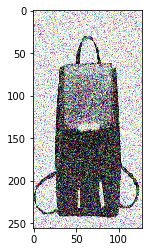

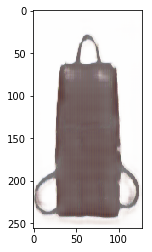

W0716 11:59:31.810074 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


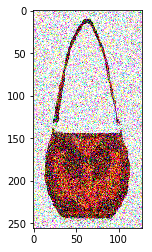

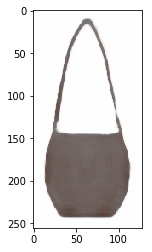

W0716 12:01:10.426585 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


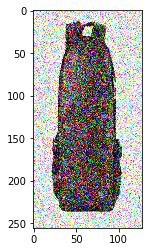

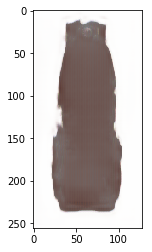

W0716 12:03:04.094248 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


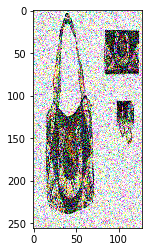

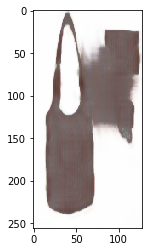

W0716 12:05:11.220384 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


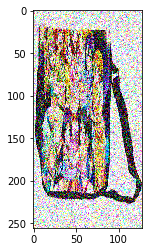

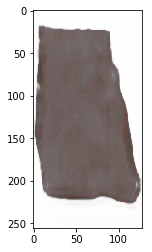

W0716 12:06:54.391236 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


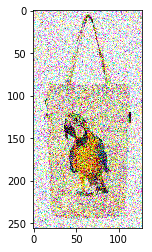

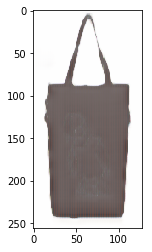

W0716 12:08:36.573984 140527429752704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


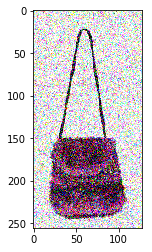

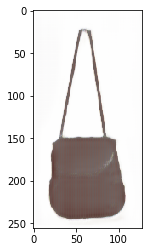

In [0]:
pix2pix = Pipi(
    train_generator,
)

pix2pix.train()